In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import numpy as np
import nibabel as nib
from pathlib import Path
import pandas as pd
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from typing import Tuple, List, Dict, Optional
import random
import matplotlib.pyplot as plt
import contextlib
import sys
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
import segmentation_models_pytorch as smp # needs installation
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import wandb
from torch.utils.checkpoint import checkpoint
import io

ModuleNotFoundError: No module named 'segmentation_models_pytorch'

## Data Preparing

In [2]:
# Create a meta file for nii files processing
volumes_part_1 = [f"/kaggle/input/liver-tumor-segmentation/volume_pt{i}" for i in range(1,6)]
volumes_part_2 = [f"/kaggle/input/liver-tumor-segmentation-part-2/volume_pt{i}" for i in range(6,9,2)]

volumes = volumes_part_1 + volumes_part_2
file_list = []

for v in volumes:
    for root, dirs, files in os.walk(v):
        for file in files:
            file_list.append((root, file))

df_files = pd.DataFrame(file_list, columns =['dirname', 'filename'])
df_files

,dirname,filename
0,/kaggle/input/liver-tumor-segmentation/volume_pt1,volume-3.nii
1,/kaggle/input/liver-tumor-segmentation/volume_pt1,volume-8.nii
2,/kaggle/input/liver-tumor-segmentation/volume_pt1,volume-9.nii
3,/kaggle/input/liver-tumor-segmentation/volume_pt1,volume-4.nii
4,/kaggle/input/liver-tumor-segmentation/volume_pt1,volume-10.nii
...,...,...
126,/kaggle/input/liver-tumor-segmentation-part-2/...,volume-104.nii
127,/kaggle/input/liver-tumor-segmentation-part-2/...,volume-130.nii
128,/kaggle/input/liver-tumor-segmentation-part-2/...,volume-117.nii
129,/kaggle/input/liver-tumor-segmentation-part-2/...,volume-119.nii


In [3]:
# Add 2 new columns for the segmentations
df_files["seg_dirname"]  = ""
df_files["seg_filename"] = ""

for i in range(138):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"

    df_files.loc[df_files['filename'] == ct, 'seg_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'seg_dirname'] = "/kaggle/input/liver-tumor-segmentation/segmentations"

print(len(df_files))

131


## Data Preprocessing

In [4]:
class CTScanProcessor:

    def __init__(self):
        # Define Hounsfield Unit (HU) windows
        self.windows = {
            'liver': (120, 60),       # (width, level) - narrower, enhances liver contrast
            'soft_tissue': (350, 50), # general soft tissue for context
            'bone': (1800, 400),      # optional for future use
            'lung': (1500, -600),
            'custom': (150, 70)
        }
        # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    def read_nii_volume(self, filepath: str) -> np.ndarray:
        """Read NIfTI file as a NumPy array."""
        return nib.load(filepath, mmap=True)
    def read_nii_slice(self, volume, slice_idx, dt) -> np.ndarray:
        """Read NIfTI file as a NumPy array."""
        data = np.array(volume.dataobj[..., slice_idx], dtype=dt)
        return data

    def apply_window(self, image: np.ndarray, window: Tuple[int, int]) -> np.ndarray:
        """Apply windowing to a CT slice."""
        width, level = window
        min_val = level - width // 2
        max_val = level + width // 2
        windowed = np.clip(image, min_val, max_val)
        # Normalize to [0, 1]
        windowed = (windowed - min_val) / (max_val - min_val)
        return windowed.astype(np.float32)

    def histogram_equalization(self, image: np.ndarray, n_bins: int = 256) -> np.ndarray:
        """Apply adaptive histogram equalization"""
        # Convert to uint8 for histogram equalization
        img_uint8 = (image * 255).astype(np.uint8)
        equalized = self.clahe.apply(img_uint8)
        return equalized.astype(np.float32) / 255.0

    def create_multi_channel(self, slice_data: np.ndarray,
                             windows: List[str] = ['liver', 'soft_tissue', 'custom']) -> np.ndarray:
        """
        Create a 2-channel representation using two selected window settings.
        Example: ['liver', 'soft_tissue'].
        """
        channels = []
        for window_name in windows:
            if window_name in self.windows:
                windowed = self.apply_window(slice_data, self.windows[window_name])
                channels.append(windowed)

        # Stack into (H, W, C)
        multi_channel = np.stack(channels, axis=-1)
        return multi_channel


### Testing samples

Processing CT file: /kaggle/input/liver-tumor-segmentation/volume_pt3/volume-25.nii
Processing Mask file: /kaggle/input/liver-tumor-segmentation/segmentations/segmentation-25.nii
Original CT array shape: (512, 512, 601)
Original Mask array shape: (512, 512, 601)


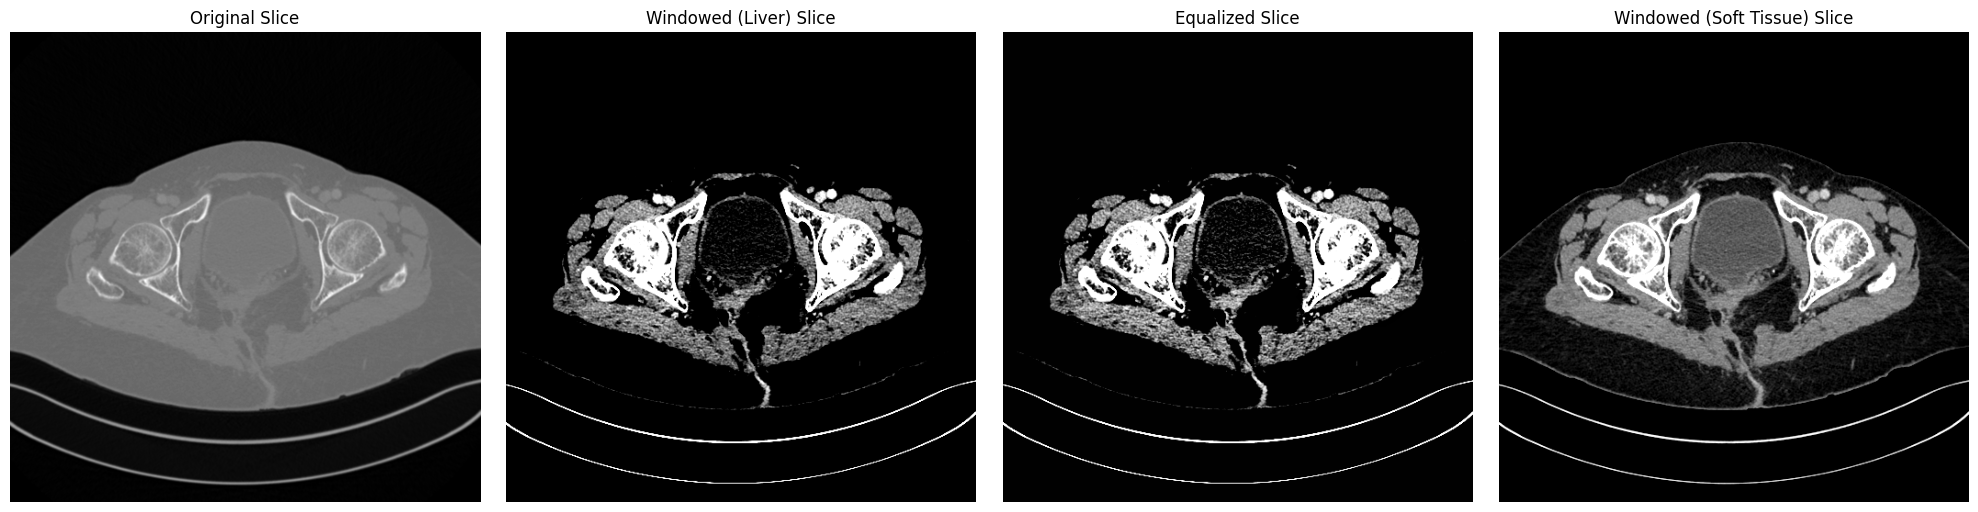

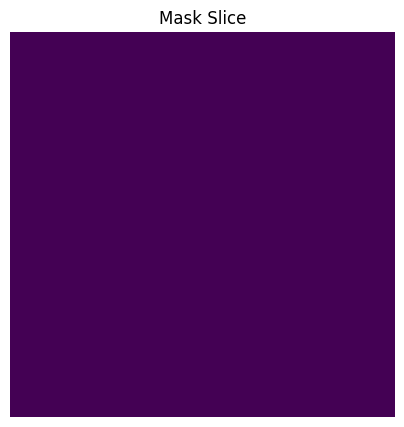

In [20]:
# Select a random volume and segmentation file from the dataframe
ct_path = "/kaggle/input/liver-tumor-segmentation/volume_pt3/volume-25.nii"
mask_path = "/kaggle/input/liver-tumor-segmentation/segmentations/segmentation-25.nii"

print(f"Processing CT file: {ct_path}")
print(f"Processing Mask file: {mask_path}")

# Initialize CTScanProcessor
processor = CTScanProcessor()

# Read NIfTI files
ct_array = processor.read_nii_volume(ct_path)
mask_array = processor.read_nii_volume(mask_path)

print(f"Original CT array shape: {ct_array.shape}")
print(f"Original Mask array shape: {mask_array.shape}")

# Select a random slice
random_slice_idx = 100
ct_slice = np.rot90(processor.read_nii_slice(ct_array, random_slice_idx, np.float32))
mask_slice = np.rot90(processor.read_nii_slice(mask_array, random_slice_idx, np.uint8))

# Apply windowing (using 'liver' window as an example)
windowed_slice = processor.apply_window(ct_slice, processor.windows['liver'])

# Apply histogram equalization
equalized_slice = processor.histogram_equalization(windowed_slice)

# Apply windowing (using 'liver' window as an example)
soft_tissue_slice = processor.apply_window(ct_slice, processor.windows['soft_tissue'])

# Visualize the original, windowed, equalized, and multi-channel slices
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

axes[0].imshow(ct_slice, cmap='gray')
axes[0].set_title('Original Slice')

axes[1].imshow(windowed_slice, cmap='gray')
axes[1].set_title('Windowed (Liver) Slice')

axes[2].imshow(equalized_slice, cmap='gray')
axes[2].set_title('Equalized Slice')

axes[3].imshow(soft_tissue_slice, cmap='gray')
axes[3].set_title('Windowed (Soft Tissue) Slice')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

# Display mask slice'
plt.figure(figsize=(5, 5))
plt.imshow(mask_slice, cmap='viridis') # viridis is a good cmap for masks
plt.title('Mask Slice')
plt.axis('off')
plt.show()

### Calculating Mean + STD

In [6]:
processor = CTScanProcessor()

def compute_mean_std_from_volumes(df, sample_every_n_slices=10):
    """
    Compute dataset mean and std for CT volumes without transforms.
    Only samples every Nth slice to reduce computation.
    """
    channel_sums = None
    channel_squared_sums = None
    total_pixels = 0

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing volumes"):
        volume_path = os.path.join(row['dirname'], row['filename'])
        ct_img = processor.read_nii_volume(volume_path).get_fdata()

        # Normalize intensity per slice (via windowing) and create multi-channel
        for slice_idx in range(0, ct_img.shape[2], sample_every_n_slices):
            slice_data = ct_img[:, :, slice_idx]
            multi_channel = processor.create_multi_channel(slice_data)

            # Convert to float32 for safety
            img = multi_channel.astype(np.float32)

            # Compute per-channel sums
            if channel_sums is None:
                n_channels = img.shape[-1]
                channel_sums = np.zeros(n_channels, dtype=np.float64)
                channel_squared_sums = np.zeros(n_channels, dtype=np.float64)

            channel_sums += img.mean(axis=(0, 1))
            channel_squared_sums += (img ** 2).mean(axis=(0, 1))
            total_pixels += 1

    # Compute mean and std
    mean = channel_sums / total_pixels
    std = np.sqrt(channel_squared_sums / total_pixels - mean ** 2)
    return mean, std


mean, std = compute_mean_std_from_volumes(df_files[:50], sample_every_n_slices=10)
print(f"\nDataset Mean: {mean}")
print(f"Dataset Std:  {std}")

Processing volumes:   8%|▊         | 4/50 [00:37<07:16,  9.48s/it]


KeyboardInterrupt: 

## Building the Dataset

In [13]:
class LiverTumorDataset(Dataset):
    """
    Custom Dataset for liver tumor segmentation that loads and processes
    CT scans on-demand during training
    """

    def __init__(self,
                 df_files: pd.DataFrame,
                 processor: CTScanProcessor,
                 transforms=None,
                mode: str = "train"):

        self.df_files = df_files
        self.processor = processor
        self.transforms = transforms
        self.mode = mode
        self.min_liver_area = 100   # Minimum liver pixels to include slice

        # Build Slices
        self.slices = self._build_slice_index()
        print(f"Total Slices: {len(self.slices)}")


    def _build_slice_index(self) -> List[Dict]:
        """Build index of all valid and empty slices across all volumes"""
        slice_index = []

        print(f"Building slice index for {self.mode} set...")

        for idx, row in self.df_files.iterrows():
            try:
                # Load mask to check which slices contain liver/tumor
                mask_path = f"{row['seg_dirname']}/{row['seg_filename']}"
                mask_volume = self.processor.read_nii_volume(mask_path)

                n_slices = mask_volume.shape[2]

                for slice_idx in range(0, n_slices):
                    # Extract slice data using dataobj
                    mask_slice_data = self.processor.read_nii_slice(mask_volume, slice_idx, np.uint8)

                    # Count liver pixels (assuming label 1 = liver, 2 = tumor)
                    liver_pixels = np.sum(mask_slice_data == 1)
                    tumor_pixels = np.sum(mask_slice_data == 2)

                    slice_info = {
                        'volume_idx': idx,
                        'slice_idx': slice_idx,
                        'ct_path': f"{row['dirname']}/{row['filename']}",
                        'mask_path': mask_path,
                        'liver_pixels': liver_pixels,
                        'tumor_pixels': tumor_pixels,
                        'has_tumor': tumor_pixels > 0
                    }

                    # Include slice if it has sufficient liver pixels
                    if liver_pixels >= self.min_liver_area:
                        slice_index.append(slice_info)

            except Exception as e:
                print(f"Error processing volume {idx}: {e}")
                continue

        liver_slices = len(slice_index)
        tumor_slices = sum(1 for s in slice_index if s['has_tumor'])
        print(f"Slices with liver: {liver_slices}")
        print(f"Slices with tumors: {tumor_slices}")

        return slice_index


    def __len__(self):
        return len(self.slices)

    def __getitem__(self, idx):
        slice_info = self.slices[idx]

        try:
            # Load CT volume and extract slice using dataobj
            ct_volume = self.processor.read_nii_volume(slice_info['ct_path'])
            ct_slice = self.processor.read_nii_slice(ct_volume, slice_info['slice_idx'], np.float32)
            

            # Load mask volume and extract slice using dataobj
            mask_volume = self.processor.read_nii_volume(slice_info['mask_path'])
            mask_slice = self.processor.read_nii_slice(mask_volume, slice_info['slice_idx'], np.uint8)

            # Create multi-channel image
            image = self.processor.create_multi_channel(ct_slice).astype(np.float32)

            # Apply transforms
            if self.transforms:
                # Albumentations expects uint8
                image_uint8 = (image * 255).astype(np.uint8)

                augmented = self.transforms(image=image_uint8, mask=mask_slice)
                image = augmented['image'].float()
                mask = augmented['mask'].long()
            else:
                image = torch.from_numpy(image).permute(2, 0, 1).float()
                mask = torch.from_numpy(mask_slice).long()

            return image, mask

        except Exception as e:
            print(f"Error loading slice {idx}: {e}")
            # Return a dummy sample in case of error
            # Ensure dummy sample shape matches expected output after transforms/processing
            dummy_image = torch.zeros(3, 512, 512) # Assuming image_size 512 from get_transforms
            dummy_mask = torch.zeros(512, 512, dtype=torch.long)
            return dummy_image, dummy_mask

In [14]:
def get_transforms(mode):
    """Define augmentation transforms for training and validation"""
    if mode == "train":
        transforms = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.2),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
            A.OneOf([
                A.MotionBlur(p=0.2),
                A.MedianBlur(blur_limit=3, p=0.1),
                A.Blur(blur_limit=3, p=0.1),
            ], p=0.3),
            A.Resize(512, 512),
            A.Normalize(mean=(0.12492581, 0.15350358, 0.11434218),
                        std=(0.28319961, 0.25778455, 0.26172392)),
            ToTensorV2()
        ])

    elif mode == "val":
        transforms = A.Compose([
            A.Resize(512, 512),
            A.Normalize(mean=(0.12492581, 0.15350358, 0.11434218),
                        std=(0.28319961, 0.25778455, 0.26172392)),
            ToTensorV2()
        ])
        
    return transforms

In [15]:
def create_data_loaders(df_files: pd.DataFrame,
                       train_ratio: float = 0.8,
                       batch_size: int = 16,
                       image_size: int = 512,
                       num_workers: int = 2) -> Tuple[DataLoader, DataLoader]:
    """Create training and validation data loaders with tumor ratio balancing"""
    import random
    
    # Spliting data (volume-level)
    n_train = int(len(df_files) * train_ratio)
    n_val = int(len(df_files) * (1 - train_ratio))
    val_df = df_files.iloc[:n_val].reset_index(drop=True)
    train_df = df_files.iloc[n_val:].reset_index(drop=True)
    print(f"Train volumes: {len(train_df)}, Val volumes: {len(val_df)}")
    
    # Initializing processor and transforms
    processor = CTScanProcessor()
    train_transforms = get_transforms("train")
    val_transforms = get_transforms("val")
    
    # Creating datasets
    train_dataset = LiverTumorDataset(train_df, processor, train_transforms, "train")
    val_dataset = LiverTumorDataset(val_df, processor, val_transforms, "validation")
    
    # Build DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    return train_loader, val_loader

In [16]:
train_loader, val_loader = create_data_loaders(
    df_files,
    train_ratio=0.8,
    batch_size=16,
    image_size=512,
    num_workers=2
)

Train volumes: 105, Val volumes: 26
Building slice index for train set...
Slices with liver: 14832
Slices with tumors: 5660
Total Slices: 14832
Building slice index for validation set...
Slices with liver: 4146
Slices with tumors: 1474
Total Slices: 4146


### Testing Data Shapes

In [19]:
for batch_idx, (images, masks) in enumerate(train_loader):
    print(f"Batch {batch_idx}:")
    print(f"Images shape: {images.shape}")  # Should be [B, 3, H, W]
    print(f"Masks shape: {masks.shape}")    # Should be [B, H, W]
    print(f"Unique mask values: {torch.unique(masks)}")  # Should be [0, 1, 2]

    if batch_idx == 2:  # Just test a few batches
        break

Batch 0:
Images shape: torch.Size([16, 3, 512, 512])
Masks shape: torch.Size([16, 512, 512])
Unique mask values: tensor([0, 1, 2])
Batch 1:
Images shape: torch.Size([16, 3, 512, 512])
Masks shape: torch.Size([16, 512, 512])
Unique mask values: tensor([0, 1, 2])
Batch 2:
Images shape: torch.Size([16, 3, 512, 512])
Masks shape: torch.Size([16, 512, 512])
Unique mask values: tensor([0, 1, 2])


## Building the Model

In [22]:
class LiverTumorSegmentationModel(nn.Module):
    """
    Segmentation model for liver tumor detection
    Uses U-Net architecture with EfficientNet encoder
    """

    def __init__(self,
                 encoder_name: str = 'efficientnet-b3',
                 encoder_weights: str = 'imagenet',
                 in_channels: int = 3,
                 classes: int = 3):  # background, liver, tumor

        super().__init__()

        self.model = smp.UnetPlusPlus(
            encoder_name=encoder_name,
            encoder_weights=encoder_weights,
            in_channels=in_channels,
            classes=classes,
            activation=None  # We'll apply softmax in loss function
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.model(x)
        return features

## Defining The Loss and Metrics

In [18]:
class DiceLoss(nn.Module):
    def __init__(self, smooth: float = 1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, predictions, targets):
        # predictions: [B, C, H, W], targets: [B, H, W]
        num_classes = predictions.size(1)
        targets_one_hot = F.one_hot(targets, num_classes).permute(0, 3, 1, 2).float()
        probs = F.softmax(predictions, dim=1)

        dice_per_class = []
        for c in range(num_classes):
            pred_c = probs[:, c]
            target_c = targets_one_hot[:, c]
            # Compute dice per image, then mean
            intersection = (pred_c * target_c).flatten(1).sum(-1)
            union = pred_c.flatten(1).sum(-1) + target_c.flatten(1).sum(-1)
            dice = (2 * intersection + self.smooth) / (union + self.smooth)
            dice_per_class.append(dice.mean())

        return 1 - torch.mean(torch.stack(dice_per_class))

class CombinedLoss(nn.Module):
    """Combined Cross Entropy and Dice Loss"""

    def __init__(self, ce_weight: float = 0.5, dice_weight: float = 0.5,
                 class_weights: torch.Tensor = None):
        super(CombinedLoss, self).__init__()
        self.ce_weight = ce_weight
        self.dice_weight = dice_weight

        self.ce_loss = nn.CrossEntropyLoss(weight=class_weights)
        self.dice_loss = DiceLoss()

    def forward(self, predictions: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        ce = self.ce_loss(predictions, targets)
        dice = self.dice_loss(predictions, targets)

        return self.ce_weight * ce + self.dice_weight * dice

In [19]:
class MetricsCalculator:
    """Calculate various metrics for segmentation"""

    @staticmethod
    def dice_coefficient(pred: torch.Tensor, target: torch.Tensor,
                        class_idx: int, smooth: float = 1e-6) -> float:
        """Calculate Dice coefficient for a specific class"""
        pred_class = (pred == class_idx).float()
        target_class = (target == class_idx).float()

        intersection = (pred_class * target_class).sum()
        union = pred_class.sum() + target_class.sum()

        dice = (2. * intersection + smooth) / (union + smooth)
        return dice.item()

    @staticmethod
    def iou_score(pred: torch.Tensor, target: torch.Tensor,
                  class_idx: int, smooth: float = 1e-6) -> float:
        """Calculate IoU for a specific class"""
        pred_class = (pred == class_idx).float()
        target_class = (target == class_idx).float()

        intersection = (pred_class * target_class).sum()
        union = pred_class.sum() + target_class.sum() - intersection

        iou = (intersection + smooth) / (union + smooth)
        return iou.item()

    @staticmethod
    def calculate_batch_metrics(predictions: torch.Tensor,
                              targets: torch.Tensor) -> Dict[str, float]:
        """Calculate metrics for a batch"""
        # Convert predictions to class indices
        pred_classes = torch.argmax(predictions, dim=1)

        metrics = {}

        # Calculate metrics for each class
        for class_idx, class_name in enumerate(['background', 'liver', 'tumor']):
            dice = MetricsCalculator.dice_coefficient(pred_classes, targets, class_idx)
            iou = MetricsCalculator.iou_score(pred_classes, targets, class_idx)

            metrics[f'dice_{class_name}'] = dice
            metrics[f'iou_{class_name}'] = iou

        # Overall accuracy
        accuracy = (pred_classes == targets).float().mean().item()
        metrics['accuracy'] = accuracy

        return metrics

## Model Trainer

In [20]:
def set_requires_grad(module, requires_grad: bool):
    """Enable/disable gradients for a module"""
    if isinstance(module, (list, tuple)):
        for m in module:
            set_requires_grad(m, requires_grad)
    else:
        for param in module.parameters():
            param.requires_grad = requires_grad


def print_trainable_layers(model):
    """Debug helper to show which layers are trainable"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable params: {trainable_params}/{total_params} "
          f"({100 * trainable_params / total_params:.2f}%)")

In [25]:
class LiverTumorTrainer:
    """Training pipeline for liver tumor segmentation"""

    def __init__(self,
                 model: nn.Module,
                 train_loader,
                 val_loader,
                 device: torch.device,
                 config: dict):

        # Detect and wrap with DataParallel if multiple GPUs are available
        # Detect GPUs and move model before wrapping
        # if torch.cuda.is_available():
        #     model = model.to(device)
        
        # if torch.cuda.device_count() > 1:
        #     print(f"Using {torch.cuda.device_count()} GPUs!")
        #     model = nn.DataParallel(model)
        # else:
        #     print("Using a single GPU")

        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.config = config

        # Step 1: Freeze encoder, train only decoder + segmentation head
        set_requires_grad(self.model.model.encoder, False)
        set_requires_grad(self.model.model.decoder, True)
        set_requires_grad(self.model.model.segmentation_head, True)
        
        print("Encoder frozen. Training decoder and head first.")
        print_trainable_layers(self.model)

        # Loss function with class weights (tumor class is rare)
        class_weights = torch.tensor([0.1, 3.0, 10.0]).to(device)  # background, liver, tumor
        self.criterion = CombinedLoss(
            ce_weight=0.4,
            dice_weight=0.6,
            class_weights=class_weights
        )

        # Optimizer and scheduler
        self.optimizer = AdamW(
            model.parameters(),
            lr=config['learning_rate'],
            weight_decay=config['weight_decay']
        )

        self.scheduler = ReduceLROnPlateau(
            self.optimizer, mode='max',
            factor=0.5,
            patience=5
        )

        self.metrics_calculator = MetricsCalculator()
        self.best_val_dice = 0.0
        self.train_losses = []
        self.val_losses = []
        self.patience = config.get('patience', 3) # Early stopping patience
        self.epochs_without_improvement = 0

    def progressive_unfreeze(self, epoch: int):
        """Gradually unfreeze encoder layers based on epoch"""
        encoder = self.model.model.encoder
    
        # Example schedule
        if epoch == 5:
            print("Unfreezing encoder last 5 blocks")
            set_requires_grad(encoder._blocks[-5:], True)
    
        elif epoch == 10:
            print("Unfreezing encoder last 10 blocks")
            set_requires_grad(encoder._blocks[-10:-5], True)
    
        elif epoch == 15:
            print("Unfreezing entire encoder")
            set_requires_grad(encoder, True)

        if epoch in [5, 10, 15]:
            for g in self.optimizer.param_groups:
                g['lr'] *= 0.5
            print(f"Learning rate reduced to {self.optimizer.param_groups[0]['lr']:.6f}")

    
        print_trainable_layers(self.model)

    def train_epoch(self) -> Dict[str, float]:
        """Train for one epoch"""
        self.model.train()
        total_loss = 0.0
        all_metrics = {
            'dice_liver': [], 'dice_tumor': [], 'dice_background': [],
            'iou_liver': [], 'iou_tumor': [], 'iou_background': [],
            'accuracy': []
        }

        pbar = tqdm(self.train_loader, desc='Training')

        for batch_step, (images, masks) in enumerate(pbar):
            images, masks = images.to(self.device), masks.to(self.device)

            # Forward pass
            outputs = self.model(images)
            loss = self.criterion(outputs, masks)
            loss_value = loss.item()
            # Backward pass
            (loss / self.config['accumulation_steps']).backward()

            if (batch_step + 1) % self.config['accumulation_steps'] == 0 or (batch_step + 1) == len(self.train_loader):
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

                self.optimizer.step()
                self.optimizer.zero_grad()

            total_loss += loss_value

            # Calculate metrics
            with torch.no_grad():
                batch_metrics = self.metrics_calculator.calculate_batch_metrics(
                    outputs, masks
                )

                for key, value in batch_metrics.items():
                    if key in all_metrics:
                        all_metrics[key].append(value)

            # Update progress bar
            pbar.set_postfix({
                'loss': f'{loss_value:.4f}',
                'liver_dice': f'{batch_metrics.get("dice_liver", 0):.3f}',
                'tumor_dice': f'{batch_metrics.get("dice_tumor", 0):.3f}',
                'liver_iou': f'{batch_metrics.get("iou_liver", 0):.3f}',
                'tumor_iou': f'{batch_metrics.get("iou_tumor", 0):.3f}'
            })

        # Calculate epoch metrics
        epoch_metrics = {key: np.mean(values) for key, values in all_metrics.items()}
        epoch_metrics['loss'] = total_loss / len(self.train_loader)

        return epoch_metrics

    def validate_epoch(self) -> Dict[str, float]:
        """Validate for one epoch"""
        self.model.eval()
        total_loss = 0.0
        all_metrics = {
            'dice_liver': [], 'dice_tumor': [], 'dice_background': [],
            'iou_liver': [], 'iou_tumor': [], 'iou_background': [],
            'accuracy': []
        }

        with torch.no_grad():
            pbar = tqdm(self.val_loader, desc='Validation')

            for images, masks in pbar:
                images = images.to(self.device)
                masks = masks.to(self.device)

                outputs = self.model(images)
                loss = self.criterion(outputs, masks)

                total_loss += loss.item()

                # Calculate metrics
                batch_metrics = self.metrics_calculator.calculate_batch_metrics(
                    outputs, masks
                )

                for key, value in batch_metrics.items():
                    if key in all_metrics:
                        all_metrics[key].append(value)

                # Update progress bar
                pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'liver_dice': f'{batch_metrics.get("dice_liver", 0):.3f}',
                    'tumor_dice': f'{batch_metrics.get("dice_tumor", 0):.3f}',
                    'liver_iou': f'{batch_metrics.get("iou_liver", 0):.3f}',
                    'tumor_iou': f'{batch_metrics.get("iou_tumor", 0):.3f}'
                })

        # Calculate epoch metrics
        epoch_metrics = {key: np.mean(values) for key, values in all_metrics.items()}
        epoch_metrics['loss'] = total_loss / len(self.val_loader)

        return epoch_metrics

    def train(self, start_epoch) -> Dict[str, list]:
        """Complete training loop"""
        print("Starting training...")

        training_history = {
            'train_loss': [], 'val_loss': [],
            'train_dice_liver': [], 'val_dice_liver': [],
            'train_dice_tumor': [], 'val_dice_tumor': [],
            'train_iou_liver': [], 'val_iou_liver': [],
            'train_iou_tumor': [], 'val_iou_tumor': []
        }

        for epoch in range(start_epoch, self.config['epochs'] + 1):
            print(f"\nEpoch {epoch}/{self.config['epochs']}")
            print("-" * 50)

            # Unfreeze progressively
            self.progressive_unfreeze(epoch)
            
            # Training
            train_metrics = self.train_epoch()

            # Validation
            val_metrics = self.validate_epoch()

            # Store history
            training_history['train_loss'].append(train_metrics['loss'])
            training_history['val_loss'].append(val_metrics['loss'])
            
            training_history['train_dice_liver'].append(train_metrics['dice_liver'])
            training_history['val_dice_liver'].append(val_metrics['dice_liver'])
            training_history['train_dice_tumor'].append(train_metrics['dice_tumor'])
            training_history['val_dice_tumor'].append(val_metrics['dice_tumor'])
            
            training_history['train_iou_liver'].append(train_metrics['iou_liver'])
            training_history['val_iou_liver'].append(val_metrics['iou_liver'])
            training_history['train_iou_tumor'].append(train_metrics['iou_tumor'])
            training_history['val_iou_tumor'].append(val_metrics['iou_tumor'])

            # Print epoch summary
            print(f"Train Loss: {train_metrics['loss']:.4f} | "
                  f"Val Loss: {val_metrics['loss']:.4f}")
            print(f"Train Liver Dice: {train_metrics['dice_liver']:.4f} | "
                  f"Val Liver Dice: {val_metrics['dice_liver']:.4f}")
            print(f"Train Tumor Dice: {train_metrics['dice_tumor']:.4f} | "
                  f"Val Tumor Dice: {val_metrics['dice_tumor']:.4f}")
            print(f"Train Liver IoU:  {train_metrics['iou_liver']:.4f} | "
                  f"Val Liver IoU:  {val_metrics['iou_liver']:.4f}")
            print(f"Train Tumor IoU:  {train_metrics['iou_tumor']:.4f} | "
                  f"Val Tumor IoU:  {val_metrics['iou_tumor']:.4f}")

            
            current_val_dice = np.mean([val_metrics['dice_liver'], val_metrics['dice_tumor']])

            # Save best model and check for early stopping
            if current_val_dice > self.best_val_dice:
                self.best_val_dice = current_val_dice
                self.epochs_without_improvement = 0  # Reset counter
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'best_val_dice': self.best_val_dice,
                    'config': self.config
                }, 'best_liver_tumor_model.pth')
                print(f"New best model saved! Tumor Val Dice: {self.best_val_dice:.4f}")
            else:
                self.epochs_without_improvement += 1
                print(f"No improvement in the validation dice for {self.epochs_without_improvement} epochs.")
                if self.epochs_without_improvement >= self.patience:
                    print(f"Early stopping triggered after {self.patience} epochs without improvement.")
                    break # Stop training

        return training_history

In [26]:
# Training configuration
def get_training_config():
    return {
        'learning_rate': 1e-4,
        'weight_decay': 1e-5,
        'epochs': 25,
        'batch_size': 8,
        'image_size': 512,
        'accumulation_steps': 2
    }

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [47]:
model = LiverTumorSegmentationModel(
    encoder_name='efficientnet-b3',
    encoder_weights='imagenet',
    in_channels=3,
    classes=3
)

In [48]:
config = get_training_config()
trainer = LiverTumorTrainer(model, train_loader, val_loader, device, config)

Encoder frozen. Training decoder and head first.
Trainable params: 2928851/13625083 (21.50%)


In [53]:
history = trainer.train(1)

Starting training...

Epoch 1/20
--------------------------------------------------
Trainable params: 2928851/13625083 (21.50%)


Validation: 100%|██████████| 519/519 [02:21<00:00,  3.68it/s, loss=0.4559, liver_dice=0.659, tumor_dice=1.000, liver_iou=0.491, tumor_iou=1.000]


Train Loss: 0.2702 | Val Loss: 0.2605
Train Liver Dice: 0.8689 | Val Liver Dice: 0.8669
Train Tumor Dice: 0.4756 | Val Tumor Dice: 0.2705
Train Liver IoU:  0.7715 | Val Liver IoU:  0.7860
Train Tumor IoU:  0.3514 | Val Tumor IoU:  0.2194
New best model saved! Tumor Val Dice: 0.5687

Epoch 2/20
--------------------------------------------------
Trainable params: 2928851/13625083 (21.50%)


Validation: 100%|██████████| 519/519 [02:20<00:00,  3.69it/s, loss=0.4305, liver_dice=0.619, tumor_dice=1.000, liver_iou=0.448, tumor_iou=1.000]


Train Loss: 0.2329 | Val Loss: 0.2559
Train Liver Dice: 0.9086 | Val Liver Dice: 0.8752
Train Tumor Dice: 0.5899 | Val Tumor Dice: 0.2837
Train Liver IoU:  0.8340 | Val Liver IoU:  0.7975
Train Tumor IoU:  0.4588 | Val Tumor IoU:  0.2308
New best model saved! Tumor Val Dice: 0.5795

Epoch 3/20
--------------------------------------------------
Trainable params: 2928851/13625083 (21.50%)


Validation: 100%|██████████| 519/519 [02:20<00:00,  3.69it/s, loss=0.4495, liver_dice=0.606, tumor_dice=1.000, liver_iou=0.435, tumor_iou=1.000]


Train Loss: 0.2203 | Val Loss: 0.2384
Train Liver Dice: 0.9185 | Val Liver Dice: 0.8975
Train Tumor Dice: 0.6359 | Val Tumor Dice: 0.4699
Train Liver IoU:  0.8505 | Val Liver IoU:  0.8315
Train Tumor IoU:  0.5072 | Val Tumor IoU:  0.4191
New best model saved! Tumor Val Dice: 0.6837

Epoch 4/20
--------------------------------------------------
Trainable params: 2928851/13625083 (21.50%)


Validation: 100%|██████████| 519/519 [02:20<00:00,  3.69it/s, loss=0.4290, liver_dice=0.639, tumor_dice=1.000, liver_iou=0.470, tumor_iou=1.000]


Train Loss: 0.2111 | Val Loss: 0.2294
Train Liver Dice: 0.9261 | Val Liver Dice: 0.8975
Train Tumor Dice: 0.6786 | Val Tumor Dice: 0.3009
Train Liver IoU:  0.8633 | Val Liver IoU:  0.8303
Train Tumor IoU:  0.5534 | Val Tumor IoU:  0.2442
No improvement in the validation dice for 1 epochs.

Epoch 5/20
--------------------------------------------------
Unfreezing encoder last 5 blocks
Learning rate reduced to 0.000500
Trainable params: 8761995/13625083 (64.31%)


Validation: 100%|██████████| 519/519 [02:20<00:00,  3.68it/s, loss=0.4138, liver_dice=0.627, tumor_dice=1.000, liver_iou=0.457, tumor_iou=1.000]


Train Loss: 0.2035 | Val Loss: 0.2336
Train Liver Dice: 0.9323 | Val Liver Dice: 0.9031
Train Tumor Dice: 0.7069 | Val Tumor Dice: 0.3207
Train Liver IoU:  0.8741 | Val Liver IoU:  0.8376
Train Tumor IoU:  0.5853 | Val Tumor IoU:  0.2653
No improvement in the validation dice for 2 epochs.

Epoch 6/20
--------------------------------------------------
Trainable params: 8761995/13625083 (64.31%)


Validation: 100%|██████████| 519/519 [02:20<00:00,  3.68it/s, loss=0.4467, liver_dice=0.617, tumor_dice=1.000, liver_iou=0.446, tumor_iou=1.000]

Train Loss: 0.1942 | Val Loss: 0.2410
Train Liver Dice: 0.9426 | Val Liver Dice: 0.9185
Train Tumor Dice: 0.7350 | Val Tumor Dice: 0.3378
Train Liver IoU:  0.8919 | Val Liver IoU:  0.8618
Train Tumor IoU:  0.6185 | Val Tumor IoU:  0.2821
No improvement in the validation dice for 3 epochs.
Early stopping triggered after 3 epochs without improvement.


In [ ]:
import matplotlib as plt

def plot_training_history(history):
    """Plots training and validation loss and Dice scores over epochs."""

    epochs = range(1, len(history['train_loss']) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Dice Scores
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_dice_liver'], label='Train Liver Dice')
    plt.plot(epochs, history['val_dice_liver'], label='Validation Liver Dice')
    plt.plot(epochs, history['train_dice_tumor'], label='Train Tumor Dice')
    plt.plot(epochs, history['val_dice_tumor'], label='Validation Tumor Dice')
    plt.title('Dice Score over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Score')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Assuming 'history' variable is available from the training process
if 'history' in globals():
    plot_training_history(history)
else:
    print("Training history not found. Please run the training cell first.")

In [57]:
def process_nii(
    nii_path: str,
    output_folder: str,
    model_checkpoint: str = "/kaggle/working/best_liver_tumor_model.pth",
    device: torch.device = None,
    use_mixed_precision: bool = True
):
    """
    Run inference on every slice in a NIfTI file and save segmentation
    masks as PNG images in the output folder.
    """

    # device
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[inference] using device: {device}")

    # --- instantiate model
    model = LiverTumorSegmentationModel(
        encoder_name='efficientnet-b3',
        encoder_weights=None,
        in_channels=3,
        classes=3
    )
    ckpt = torch.load(model_checkpoint, map_location=device, weights_only=False)
    if isinstance(ckpt, dict) and "model_state_dict" in ckpt:
        model.load_state_dict(ckpt["model_state_dict"])
    else:
        model.load_state_dict(ckpt)
    model = model.to(device)
    model.eval()

    # --- processor
    processor = CTScanProcessor()

    # --- load nifti
    nif = processor.read_nii_volume(nii_path)
    n_slices = nif.shape[2]

    os.makedirs(output_folder, exist_ok=True)

    for i in tqdm(range(n_slices), desc="Infer slices"):
        ct_slice = processor.read_nii_slice(nif, i, np.float32)
        img_multi = processor.create_multi_channel(ct_slice).astype(np.float32)

        inp = torch.from_numpy(img_multi).permute(2, 0, 1).unsqueeze(0).to(device)

        with torch.no_grad():
            if device.type == "cuda" and use_mixed_precision:
                from torch.cuda.amp import autocast
                with autocast():
                    out_logits = model(inp)
            else:
                out_logits = model(inp)

            probs = F.softmax(out_logits, dim=1)
            pred = torch.argmax(probs, dim=1).squeeze(0).cpu().numpy().astype(np.uint8)

        pred_orig = np.rot90(pred, -1)  # back to original orientation

        # save segmentation as PNG
        save_path = os.path.join(output_folder, f"slice_{i:03d}.png")
        plt.imsave(save_path, pred_orig, cmap="viridis")
        # you can use cmap="gray" or define custom colors

        del inp, out_logits, probs, pred
        if device.type == "cuda":
            torch.cuda.empty_cache()

    print(f"[inference] saved {n_slices} segmentation slices to {output_folder}")

process_nii("/kaggle/input/liver-tumor-segmentation/volume_pt5/volume-45.nii", "/kaggle/working/nii45")

[inference] using device: cuda


Infer slices: 100%|██████████| 74/74 [00:04<00:00, 15.80it/s]

[inference] saved 74 segmentation slices to /kaggle/working/nii45


## Resuming Training

In [ ]:
def get_training_config():
    return {
        'learning_rate': 1e-4,
        'weight_decay': 1e-5,
        'epochs': 25,
        'batch_size': 8,
        'image_size': 512,
        'accumulation_steps': 2,
    }
config = get_training_config()

model = LiverTumorSegmentationModel(
    encoder_name='efficientnet-b3',
    encoder_weights=None,
    in_channels=3,
    classes=3
)

trainer = LiverTumorTrainer(model, train_loader, val_loader, device, config)
ckpt = torch.load("/kaggle/input/dsds/pytorch/default/1/best_liver_tumor_model (3) val_dice_0.65.pth", map_location=device, weights_only=False)

trainer.model.load_state_dict(ckpt['model_state_dict'])
trainer.optimizer.load_state_dict(ckpt['optimizer_state_dict'])
# trainer.scheduler.load_state_dict(ckpt['scheduler_state_dict'])
start_epoch = ckpt['epoch']
best_val_dice = ckpt.get('best_val_dice', None)
trainer.train(start_epoch=start_epoch)

Encoder frozen. Training decoder and head first.
Trainable params: 2928851/13625083 (21.50%)
Starting training...

Epoch 5/25
--------------------------------------------------
Unfreezing encoder last 5 blocks
Learning rate reduced to 0.000250
Trainable params: 8761995/13625083 (64.31%)


Validation: 100%|██████████| 260/260 [02:24<00:00,  1.80it/s, loss=0.4454, liver_dice=0.581, tumor_dice=1.000, liver_iou=0.410, tumor_iou=1.000]


Train Loss: 0.1916 | Val Loss: 0.2379
Train Liver Dice: 0.9468 | Val Liver Dice: 0.9166
Train Tumor Dice: 0.8121 | Val Tumor Dice: 0.3120
Train Liver IoU:  0.8991 | Val Liver IoU:  0.8574
Train Tumor IoU:  0.6941 | Val Tumor IoU:  0.2467
New best model saved! Tumor Val Dice: 0.6143

Epoch 6/25
--------------------------------------------------
Trainable params: 8761995/13625083 (64.31%)


Validation: 100%|██████████| 260/260 [02:23<00:00,  1.81it/s, loss=0.4228, liver_dice=0.610, tumor_dice=1.000, liver_iou=0.439, tumor_iou=1.000]


Train Loss: 0.1875 | Val Loss: 0.2359
Train Liver Dice: 0.9497 | Val Liver Dice: 0.9190
Train Tumor Dice: 0.8192 | Val Tumor Dice: 0.3093
Train Liver IoU:  0.9044 | Val Liver IoU:  0.8608
Train Tumor IoU:  0.7047 | Val Tumor IoU:  0.2437
No improvement in the validation dice for 1 epochs.

Epoch 7/25
--------------------------------------------------
Trainable params: 8761995/13625083 (64.31%)


Validation: 100%|██████████| 260/260 [02:23<00:00,  1.81it/s, loss=0.4785, liver_dice=0.559, tumor_dice=1.000, liver_iou=0.388, tumor_iou=1.000]


Train Loss: 0.1855 | Val Loss: 0.2295
Train Liver Dice: 0.9509 | Val Liver Dice: 0.9188
Train Tumor Dice: 0.8292 | Val Tumor Dice: 0.3193
Train Liver IoU:  0.9066 | Val Liver IoU:  0.8605
Train Tumor IoU:  0.7167 | Val Tumor IoU:  0.2537
New best model saved! Tumor Val Dice: 0.6190

Epoch 8/25
--------------------------------------------------
Trainable params: 8761995/13625083 (64.31%)


Validation: 100%|██████████| 260/260 [02:23<00:00,  1.81it/s, loss=0.4501, liver_dice=0.595, tumor_dice=1.000, liver_iou=0.424, tumor_iou=1.000]


Train Loss: 0.1833 | Val Loss: 0.2410
Train Liver Dice: 0.9520 | Val Liver Dice: 0.9232
Train Tumor Dice: 0.8334 | Val Tumor Dice: 0.3293
Train Liver IoU:  0.9085 | Val Liver IoU:  0.8669
Train Tumor IoU:  0.7238 | Val Tumor IoU:  0.2632
New best model saved! Tumor Val Dice: 0.6262

Epoch 9/25
--------------------------------------------------
Trainable params: 8761995/13625083 (64.31%)


Validation: 100%|██████████| 260/260 [02:24<00:00,  1.80it/s, loss=0.4449, liver_dice=0.597, tumor_dice=1.000, liver_iou=0.426, tumor_iou=1.000]


Train Loss: 0.1816 | Val Loss: 0.2316
Train Liver Dice: 0.9528 | Val Liver Dice: 0.9185
Train Tumor Dice: 0.8394 | Val Tumor Dice: 0.3071
Train Liver IoU:  0.9100 | Val Liver IoU:  0.8604
Train Tumor IoU:  0.7323 | Val Tumor IoU:  0.2411
No improvement in the validation dice for 1 epochs.

Epoch 10/25
--------------------------------------------------
Unfreezing encoder last 10 blocks
Learning rate reduced to 0.000125
Trainable params: 11446485/13625083 (84.01%)


Validation: 100%|██████████| 260/260 [02:24<00:00,  1.80it/s, loss=0.4720, liver_dice=0.558, tumor_dice=1.000, liver_iou=0.387, tumor_iou=1.000]


Train Loss: 0.1798 | Val Loss: 0.2370
Train Liver Dice: 0.9542 | Val Liver Dice: 0.9220
Train Tumor Dice: 0.8422 | Val Tumor Dice: 0.3474
Train Liver IoU:  0.9126 | Val Liver IoU:  0.8656
Train Tumor IoU:  0.7371 | Val Tumor IoU:  0.2820
New best model saved! Tumor Val Dice: 0.6347

Epoch 11/25
--------------------------------------------------
Trainable params: 11446485/13625083 (84.01%)


Validation: 100%|██████████| 260/260 [02:24<00:00,  1.81it/s, loss=0.4638, liver_dice=0.573, tumor_dice=1.000, liver_iou=0.402, tumor_iou=1.000]


Train Loss: 0.1779 | Val Loss: 0.2446
Train Liver Dice: 0.9552 | Val Liver Dice: 0.9192
Train Tumor Dice: 0.8511 | Val Tumor Dice: 0.3223
Train Liver IoU:  0.9144 | Val Liver IoU:  0.8613
Train Tumor IoU:  0.7486 | Val Tumor IoU:  0.2571
No improvement in the validation dice for 1 epochs.

Epoch 12/25
--------------------------------------------------
Trainable params: 11446485/13625083 (84.01%)


Validation: 100%|██████████| 260/260 [02:24<00:00,  1.80it/s, loss=0.5082, liver_dice=0.528, tumor_dice=0.000, liver_iou=0.359, tumor_iou=0.000]


Train Loss: 0.1759 | Val Loss: 0.2481
Train Liver Dice: 0.9564 | Val Liver Dice: 0.9173
Train Tumor Dice: 0.8593 | Val Tumor Dice: 0.3377
Train Liver IoU:  0.9165 | Val Liver IoU:  0.8596
Train Tumor IoU:  0.7600 | Val Tumor IoU:  0.2708
No improvement in the validation dice for 1 epochs.

Epoch 14/25
--------------------------------------------------
Trainable params: 11446485/13625083 (84.01%)


Training:  66%|██████▋   | 616/927 [14:13<07:09,  1.38s/it, loss=0.1827, liver_dice=0.963, tumor_dice=0.922, liver_iou=0.929, tumor_iou=0.856]

In [23]:
import os
import torch
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm

def visualize_model_prediction(
    nii_path: str,
    seg_path: str,
    model_checkpoint: str = "/kaggle/input/dsds/pytorch/default/1/best_liver_tumor_model (3) val_dice_0.65.pth",
    slice_idx: int = None,
    device: torch.device = None,
    save: bool = False,
    use_mixed_precision: bool = True
):
    """
    Visualize a single CT slice with ground truth and model prediction.

    Args:
        nii_path (str): Path to NIfTI volume (.nii)
        seg_path (str): Path to corresponding segmentation (.nii)
        model_checkpoint (str): Path to trained model checkpoint
        slice_idx (int): Index of slice to visualize
        device (torch.device): Torch device (default: cuda if available)
        save (bool): If True, saves the figure instead of showing it
        output_dir (str): Directory to save plots
        use_mixed_precision (bool): Whether to use mixed precision during inference
    """

    # --- device
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[visualize] using device: {device}")

    # --- instantiate model
    model = LiverTumorSegmentationModel(
        encoder_name='efficientnet-b3',
        encoder_weights=None,
        in_channels=3,
        classes=3
    )
    ckpt = torch.load(model_checkpoint, map_location=device, weights_only=False)
    if isinstance(ckpt, dict) and "model_state_dict" in ckpt:
        model.load_state_dict(ckpt["model_state_dict"])
    else:
        model.load_state_dict(ckpt)
    model = model.to(device)
    model.eval()

    # --- processor
    processor = CTScanProcessor()

    # --- load volumes
    vol = processor.read_nii_volume(nii_path)
    seg = processor.read_nii_volume(seg_path)

    vol_data = vol.get_fdata()
    seg_data = seg.get_fdata()

    # --- read CT slice and segmentation
    ct_slice = processor.read_nii_slice(vol, slice_idx, np.float32)
    seg_slice = np.array(seg_data[..., slice_idx], dtype=np.uint8)

    # --- apply liver window (for visualization)
    windowed = processor.apply_window(ct_slice, processor.windows['liver'])

    # --- rotate all images for consistent orientation
    windowed = np.rot90(windowed, k=1)
    seg_slice = np.rot90(seg_slice, k=1)

    # Histogram Equalized window
    he_window = processor.histogram_equalization(windowed)

    # --- prepare input for model
    img_multi = processor.create_multi_channel(ct_slice).astype(np.float32)
    inp = torch.from_numpy(img_multi).permute(2, 0, 1).unsqueeze(0).to(device)

    # --- run inference
    with torch.no_grad():
        if device.type == "cuda" and use_mixed_precision:
            from torch.cuda.amp import autocast
            with autocast():
                out_logits = model(inp)
        else:
            out_logits = model(inp)

        probs = F.softmax(out_logits, dim=1)
        pred = torch.argmax(probs, dim=1).squeeze(0).cpu().numpy().astype(np.uint8)

    # --- rotate prediction too
    pred = np.rot90(pred, k=1)

    # --- plot
    fig, axs = plt.subplots(1, 4, figsize=(18, 6))
    axs[0].imshow(windowed, cmap="gray")
    axs[0].set_title(f"Liver Window (Slice {slice_idx})")
    
    axs[1].imshow(he_window, cmap="gray")
    axs[1].set_title(f"Histogram Equalized Window (Slice {slice_idx})")

    axs[2].imshow(windowed, cmap="gray")
    axs[2].imshow(seg_slice, cmap="Reds", alpha=0.4)
    axs[2].set_title("Ground Truth")

    axs[3].imshow(windowed, cmap="gray")
    axs[3].imshow(pred, cmap="Blues", alpha=0.4)
    axs[3].set_title("Model Prediction")

    for ax in axs:
        ax.axis("off")

    plt.tight_layout()
    
    # --- save or show
    if save:
        base_name = os.path.splitext(os.path.basename(nii_path))[0]
        out_dir = "/kaggle/working/"
    
        # 1️⃣ Liver window only
        plt.figure(figsize=(6, 6))
        plt.imshow(windowed, cmap="gray")
        plt.axis("off")
        plt.title(f"Liver Window (Slice {slice_idx})")
        liver_path = os.path.join(out_dir, f"{base_name}_slice{slice_idx}_liver.png")
        plt.savefig(liver_path, bbox_inches="tight", pad_inches=0)
        plt.close()
        print(f"✅ Saved: {liver_path}")
        
        # 1️⃣ HE Liver window only
        # plt.figure(figsize=(6, 6))
        # plt.imshow(he_window, cmap="gray")
        # plt.axis("off")
        # plt.title(f"Histogram Equalized Window (Slice {slice_idx})")
        # liver_path = os.path.join(out_dir, f"{base_name}_slice{slice_idx}_he_liver.png")
        # plt.savefig(liver_path, bbox_inches="tight", pad_inches=0)
        # plt.close()
        # print(f"✅ Saved: {liver_path}")
    
        # 2️⃣ Ground truth
        plt.figure(figsize=(6, 6))
        plt.imshow(windowed, cmap="gray")
        plt.imshow(seg_slice, cmap="Reds", alpha=0.9)
        plt.axis("off")
        plt.title("Ground Truth")
        gt_path = os.path.join(out_dir, f"{base_name}_slice{slice_idx}_gt.png")
        plt.savefig(gt_path, bbox_inches="tight", pad_inches=0)
        plt.close()
        print(f"✅ Saved: {gt_path}")
    
        # 3️⃣ Model prediction
        plt.figure(figsize=(6, 6))
        plt.imshow(windowed, cmap="gray")
        plt.imshow(pred, cmap="Blues", alpha=0.9)
        plt.axis("off")
        plt.title("Model Prediction")
        pred_path = os.path.join(out_dir, f"{base_name}_slice{slice_idx}_pred.png")
        plt.savefig(pred_path, bbox_inches="tight", pad_inches=0)
        plt.close()
        print(f"✅ Saved: {pred_path}")
    
    else:
        # --- show in one figure if not saving
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))
        axs[0].imshow(windowed, cmap="gray")
        axs[0].set_title(f"Liver Window (Slice {slice_idx})")
    
        axs[1].imshow(windowed, cmap="gray")
        axs[1].imshow(seg_slice, cmap="Reds", alpha=1)
        axs[1].set_title("Ground Truth")
    
        axs[2].imshow(windowed, cmap="gray")
        axs[2].imshow(pred, cmap="Blues", alpha=1)
        axs[2].set_title("Model Prediction")
    
        for ax in axs:
            ax.axis("off")
        plt.tight_layout()
        plt.show()

    # --- cleanup
    del inp, out_logits, probs, pred
    if device.type == "cuda":
        torch.cuda.empty_cache()

In [41]:
visualize_model_prediction("/kaggle/input/liver-tumor-segmentation/volume_pt3/volume-25.nii",
                           "/kaggle/input/liver-tumor-segmentation/segmentations/segmentation-25.nii",
                          slice_idx = 601,
                          save = True)

[visualize] using device: cpu


ValueError: Integer index 601 too large